In [1]:
import os
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import PlaintextCorpusReader
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import FreqDist
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the path to your folder containing the text files
folder_path = r'Articles'

# Read all text files in the folder as one large string
large_character = ''
for file in os.listdir(folder_path):
    if file.endswith('.txt'):
        with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
            content = f.read()
        articles = content.split("\n\n\n")  # assuming articles are separated by three newlines
        for article in articles:
            if(len(article)!=1):
                large_character += article + '\n===END_OF_ARTICLE===\n'

# Split the large character string into individual articles
individual_articles = large_character.split('\n===END_OF_ARTICLE===\n')

# Save the individual articles as separate text files in a new folder
new_folder_path = r'New'
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

for i, article in enumerate(individual_articles):
    with open(os.path.join(new_folder_path, f'article_{i}.txt'), 'w', encoding='utf-8') as f:
        f.write(article)

# Create a corpus object with the new folder containing the split articles
corpus = PlaintextCorpusReader(new_folder_path, '.*')


In [3]:
# Function to convert to lower case
def convert_lower_case(data):
    return np.char.lower(data)

# Function to remove stop words
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

# Function to remove punctuation
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

# Function to remove apostrophe
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

# Function to stem data
def stemming(data):
    stemmer = PorterStemmer()

    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

# Function to convert numbers
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

# Function to preprocess data
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data)  # remove comma separately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data)  # needed again as we need to stem the words
    data = remove_punctuation(data)  # needed again as num2word is giving few hyphens and commas fourty-one
    data = remove_stop_words(data)  # needed again as num2word is giving stop words 101 - one hundred and one
    return data


In [4]:
def clean_article(text):
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Extract section using regex
    section = re.search(r'^(.*?);', text)
    section = section.group(1).strip() if section else ''

    # Extract title using regex
    title = re.search(r'(?<=;)(.*?)(?=\n)', text)
    title = title.group(0).strip() if title else ''
    
    # Extract author using regex
    author = re.search(r'By (.*?)\n', text)
    author = author.group(1).strip() if author else ''
    
    # Extract word count using regex
    word_count = re.search(r'(\d+) words', text)
    word_count = int(word_count.group(1)) if word_count else 0

    # Extract date using regex
    date = re.search(r'\d+ \w+ \d+', text)
    date = date.group(0).strip() if date else ''
    
    # Extract source using regex
    source = re.search(r'\n\d+\n(.*?)(?=\n)', text)
    source = source.group(1).strip() if source else ''

    # Extract language using regex
    language = re.search(r'(?<=\n)(\w+)$', text)
    language = language.group(1).strip() if language else ''

    # Remove metadata from the actual article
    text = re.sub(r'^.*?\n', '', text, count=1)  # Remove section and title
    text = re.sub(r'By .*?\n', '', text, count=1)  # Remove author
    text = re.sub(r'\d+ words.*?\n', '', text, count=1)  # Remove word count, date, and source
    text = re.sub(r'Copyright .*?\n', '', text, count=1)  # Remove copyright
    text = re.sub(r'(?<=\n)(\w+)$', '', text, count=1)  # Remove language
    text = text.strip()

    metadata = {
        'section': section,
        'title': title,
        'author': author,
        'word_count': word_count,
        'date': date,
        'source': source,
        'language': language
    }
    
    # Preprocess the text
    text = preprocess(text)
    
    return text, metadata

cleaned_corpus = [clean_article(corpus.raw(fileid)) for fileid in corpus.fileids()]


In [5]:
# Tokenize the articles
def tokenize_article(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    return tokens

tokenized_corpus = [tokenize_article(text) for text, _ in cleaned_corpus]

# Extract features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform([' '.join(tokens) for tokens in tokenized_corpus])
feature_names = vectorizer.get_feature_names()

# Create summaries using top N features
def summarize_article(tfidf_vector, feature_names, N=10):
    top_indices = tfidf_vector.toarray()[0].argsort()[-N:][::-1]
    top_features = [feature_names[index] for index in top_indices]
    summary = ' '.join(top_features)
    return summary

summaries = [summarize_article(tfidf_matrix[i], feature_names) for i in range(len(tokenized_corpus))]


c:\Users\georg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
for i in range(10):
    print(summaries[i]

nightclub turkey erdogan istanbul turkish attack coup state gunman unit
nigeria nigerian god hymn gowon shonekan obasanjo osinbajo ekwuem video
rape pregnanc pregnant birth women child yazidi dohuk contracept sex
afghanistan america pakistan terrorist sacrif enemi strategi everi militari american
trump comey comment fallon react page reader derballa avocado jimmi
dunford matti state mr islam gener american trump fighter rasmussen
syrian convoy pro state syria said unit russia govern russian
saudi iran arabia yemen trump mr arab muslim paradox ignor
comey trump presid flynn mr russian white hou report offici
matti dunford state islam gener mr trump american syria rasmussen


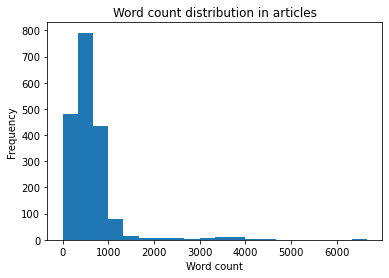

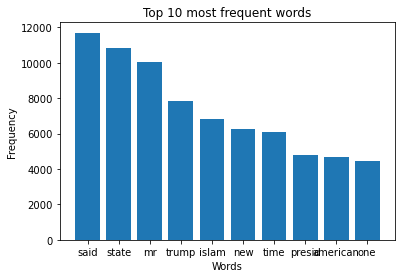

In [7]:

# Explore data: word count distribution
word_counts = [len(tokens) for tokens in tokenized_corpus]
plt.hist(word_counts, bins=20)
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.title('Word count distribution in articles')
plt.show()

# Explore data: top N most frequent words
N = 10
flat_tokens = [token for article_tokens in tokenized_corpus for token in article_tokens]
freq_dist = nltk.FreqDist(flat_tokens)
most_common = freq_dist.most_common(N)

plt.bar([word for word, _ in most_common], [count for _, count in most_common])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {N} most frequent words')
plt.show()

In [8]:
import sys
import site

user_site_packages = site.getusersitepackages()
if user_site_packages not in sys.path:
    sys.path.append(user_site_packages)


In [9]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
import seaborn as sns
import pyLDAvis # Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
# Prepare the data for the LDA model
dictionary = corpora.Dictionary(tokenized_corpus)
doc_term_matrix = [dictionary.doc2bow(tokens) for tokens in tokenized_corpus]

# Train the LDA model
num_topics = 5
lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=20, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis


c:\Users\georg\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\georg\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.072448  0.092132       1        1  28.290307
0      0.104793  0.042698       2        1  23.817248
2     -0.108259 -0.029804       3        1  19.721820
3      0.004115 -0.096249       4        1  14.348029
1      0.071799 -0.008777       5        1  13.822595, topic_info=        Term         Freq        Total Category  logprob  loglift
461    trump  7722.000000  7722.000000  Default  30.0000  30.0000
937    iraqi  2159.000000  2159.000000  Default  29.0000  29.0000
227    islam  6525.000000  6525.000000  Default  28.0000  28.0000
49    attack  4237.000000  4237.000000  Default  27.0000  27.0000
936     iraq  3038.000000  3038.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
325    peopl   470.812903  4001.814335   Topic5  -5.7932  -0.1612
1184   would   455.715076  3866.035647   Topic5  -5.8258  -0.1593
471     unit   444.219976  3662.529743   Topic5  -5.8513  -0.1307
3       2017   431.381005  3562.125144   Topic5  -5.8807  -0.1323
307   offici   413.471833  3353.238404   Topic5  -5.9231  -0.1142

[474 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
25038      4  0.958945     08trump
25039      4  0.958941     08voter
3          1  0.225708        2017
3          2  0.284381        2017
3          3  0.183318        2017
...      ...       ...         ...
29457      4  0.991469      zarrab
5238       2  0.989044        zour
19942      5  0.958859    zucchino
13223      3  0.804683  zuckerberg
13223      5  0.192269  zuckerberg

[1237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2])

    The prominence of Trump and American politics in the corpus suggests that the articles were heavily focused on the United States and its government during this time period. You could investigate the specific events or policies that were being covered during this time period.
    The topic of international relations and conflict, specifically related to Syria and Islam, suggests that there were likely many articles covering the ongoing conflict in Syria and the role of Islam in international relations. You could investigate the different perspectives presented in these articles and how they may have contributed to public perception of these issues.
    The appearance of the New York Times and the Wall Street Journal as a topic suggests that these two publications were particularly prominent in the corpus. You could investigate why these publications were chosen and whether there were any notable differences in the coverage between the two.
    The appearance of "state" and "would" as topics suggests that there may have been some discussion of hypothetical scenarios or potential government actions. You could investigate what specific scenarios or actions were being discussed and how they were being framed in the articles.

In [10]:
num_topics_list = [3, 5, 7, 10]
passes_list = [5, 10, 20]

output_folder = 'lda_output'
coherence_matrix = []
perplexity_matrix = []
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for num_topics in num_topics_list:
    coherence_row = []
    perplexity_row = []
    for passes in passes_list:
        lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_corpus, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        perplexity_score = lda_model.log_perplexity(doc_term_matrix)
        coherence_row.append(coherence_lda)
        perplexity_row.append(perplexity_score)

        output_file = f"lda_{num_topics}_topics_{passes}_passes.txt"
        with open(os.path.join(output_folder, output_file), 'w') as f:
            for idx, topic in lda_model.print_topics(-1):
                f.write(f"Topic {idx+1}: {topic}\n")
            f.write(f"Coherence Score: {coherence_lda}\n")
            f.write(f"Perplexity Score: {perplexity_score}\n")

    coherence_matrix.append(coherence_row)
    perplexity_matrix.append(perplexity_row)




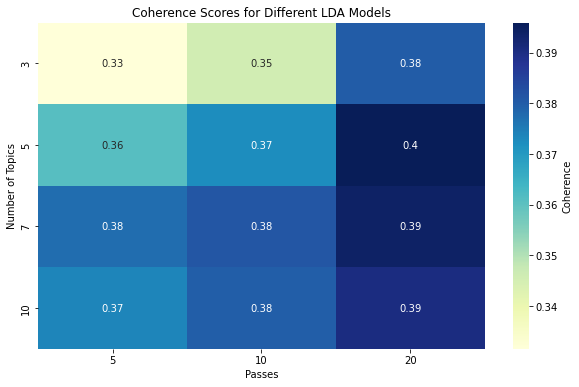

In [11]:
coherence_df = pd.DataFrame(coherence_matrix, columns=passes_list, index=num_topics_list)

plt.figure(figsize=(10, 6))
sns.heatmap(coherence_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Coherence'})
plt.xlabel('Passes')
plt.ylabel('Number of Topics')
plt.title('Coherence Scores for Different LDA Models')
plt.show()


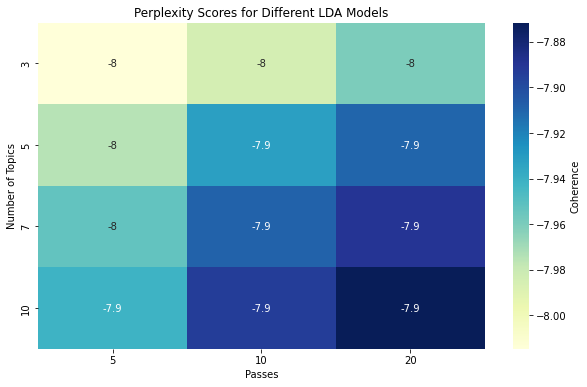

In [12]:
perplexity_df = pd.DataFrame(perplexity_matrix, columns=passes_list, index=num_topics_list)

plt.figure(figsize=(10, 6))
sns.heatmap(perplexity_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Coherence'})
plt.xlabel('Passes')
plt.ylabel('Number of Topics')
plt.title('Perplexity Scores for Different LDA Models')
plt.show()


In [13]:
def print_lda(num_topics,passes):
    output_file = f"lda_{num_topics}_topics_{passes}_passes.txt"
    with open(os.path.join(output_folder, output_file), 'r') as f:
        for line in f:
            print(line)

In [14]:
min_index = perplexity_df.values.argmin()
row_label = perplexity_df.index[min_index // len(perplexity_df.columns)]
col_label = perplexity_df.columns[min_index % len(perplexity_df.columns)]

print("Smallest perplexity is {} with {} topics and {} passes\n".format(perplexity_df.values.min(), row_label, col_label))

print_lda(row_label,col_label)

Smallest perplexity is -8.014714153764546 with 3 topics and 5 passes

Topic 1: 0.012*"said" + 0.012*"state" + 0.008*"islam" + 0.008*"mr" + 0.006*"new" + 0.006*"time" + 0.006*"syria" + 0.006*"trump" + 0.006*"forc" + 0.005*"american"

Topic 2: 0.010*"said" + 0.009*"state" + 0.006*"islam" + 0.006*"mr" + 0.005*"peopl" + 0.005*"time" + 0.005*"one" + 0.005*"trump" + 0.005*"attack" + 0.004*"go"

Topic 3: 0.012*"mr" + 0.011*"trump" + 0.008*"said" + 0.008*"state" + 0.006*"new" + 0.005*"presid" + 0.005*"time" + 0.004*"unit" + 0.004*"american" + 0.004*"would"

Coherence Score: 0.33158429391362015

Perplexity Score: -8.014714153764546



In [15]:
# Train the LDA model
num_topics = row_label
num_passes = col_label
lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=num_passes, random_state=42)

# Visualize the lowest perplexity model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.035929 -0.016147       1        1  38.434156
2     -0.035069 -0.017364       2        1  32.603356
1     -0.000860  0.033511       3        1  28.962488, topic_info=          Term         Freq        Total Category  logprob  loglift
12906    gigot  1003.000000  1003.000000  Default  30.0000  30.0000
442     syrian  2399.000000  2399.000000  Default  29.0000  29.0000
461      trump  7804.000000  7804.000000  Default  28.0000  28.0000
199         go  2661.000000  2661.000000  Default  27.0000  27.0000
937      iraqi  2182.000000  2182.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
341     presid  1039.117544  4695.977113   Topic3  -5.7412  -0.2692
226        isi   905.156124  3414.519932   Topic3  -5.8793  -0.0885
109    countri   798.310804  3222.198312   Topic3  -6.0049  -0.1562
3         2017   793.677209  3586.666937   Topic3  -6.0107  -0.2691
510       york   791.481162  3708.357494   Topic3  -6.0135  -0.3053

[304 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
25038      1  0.037521     08trump
25038      2  0.037521     08trump
25038      3  0.938034     08trump
25039      1  0.037516     08voter
25039      2  0.037516     08voter
...      ...       ...         ...
13223      1  0.022551  zuckerberg
13223      2  0.165376  zuckerberg
13223      3  0.811847  zuckerberg
16885      2  0.958189        一带一路
16885      3  0.050431        一带一路

[680 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [16]:
max_index = coherence_df.values.argmax()
row_label = coherence_df.index[max_index // len(coherence_df.columns)]
col_label = coherence_df.columns[max_index % len(coherence_df.columns)]

print("Largest coherence is {} with {} topics and {} passes\n".format(coherence_df.values.max(), row_label, col_label))

print_lda(row_label,col_label)

Largest coherence is 0.39594418160688216 with 5 topics and 20 passes

Topic 1: 0.017*"state" + 0.015*"said" + 0.012*"islam" + 0.012*"syria" + 0.009*"mr" + 0.009*"forc" + 0.009*"militari" + 0.008*"syrian" + 0.008*"american" + 0.006*"offici"

Topic 2: 0.015*"state" + 0.012*"islam" + 0.012*"said" + 0.011*"iraqi" + 0.011*"iraq" + 0.008*"mosul" + 0.006*"forc" + 0.006*"citi" + 0.006*"mr" + 0.005*"isi"

Topic 3: 0.008*"new" + 0.008*"time" + 0.005*"said" + 0.005*"like" + 0.005*"one" + 0.005*"york" + 0.005*"year" + 0.005*"peopl" + 0.004*"compani" + 0.004*"muslim"

Topic 4: 0.017*"said" + 0.014*"attack" + 0.013*"mr" + 0.007*"polic" + 0.007*"state" + 0.006*"time" + 0.006*"new" + 0.006*"islam" + 0.005*"kill" + 0.005*"york"

Topic 5: 0.020*"trump" + 0.012*"mr" + 0.010*"presid" + 0.007*"state" + 0.006*"go" + 0.006*"new" + 0.005*"said" + 0.005*"think" + 0.005*"would" + 0.005*"right"

Coherence Score: 0.39594418160688216

Perplexity Score: -7.910016834208858



In [17]:
# Train the LDA model
num_topics = row_label
num_passes = col_label
lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=num_passes, random_state=42)

# Visualize the highest coherence model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.072448  0.092132       1        1  28.290307
0      0.104793  0.042698       2        1  23.817248
2     -0.108259 -0.029804       3        1  19.721820
3      0.004115 -0.096249       4        1  14.348029
1      0.071799 -0.008777       5        1  13.822595, topic_info=        Term         Freq        Total Category  logprob  loglift
461    trump  7722.000000  7722.000000  Default  30.0000  30.0000
937    iraqi  2159.000000  2159.000000  Default  29.0000  29.0000
227    islam  6525.000000  6525.000000  Default  28.0000  28.0000
49    attack  4237.000000  4237.000000  Default  27.0000  27.0000
936     iraq  3038.000000  3038.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
325    peopl   470.812903  4001.814335   Topic5  -5.7932  -0.1612
1184   would   455.715076  3866.035647   Topic5  -5.8258  -0.1593
471     unit   444.219976  3662.529743   Topic5  -5.8513  -0.1307
3       2017   431.381005  3562.125144   Topic5  -5.8807  -0.1323
307   offici   413.471833  3353.238404   Topic5  -5.9231  -0.1142

[474 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
25038      4  0.958945     08trump
25039      4  0.958941     08voter
3          1  0.225708        2017
3          2  0.284381        2017
3          3  0.183318        2017
...      ...       ...         ...
29457      4  0.991469      zarrab
5238       2  0.989044        zour
19942      5  0.958859    zucchino
13223      3  0.804683  zuckerberg
13223      5  0.192269  zuckerberg

[1237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2])